### Bump test
performed on 3/6/20, repeated 3 times.

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters();

In [2]:
client = EfdClient('summit_efd')
csc_index = 1

In [27]:
start = Time('2020-03-06T13:20:30') #this is UTC
end = Time('2020-03-06T13:41:00') 

In [28]:
df = await client.select_time_series('lsst.sal.MTM2.axialForcesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

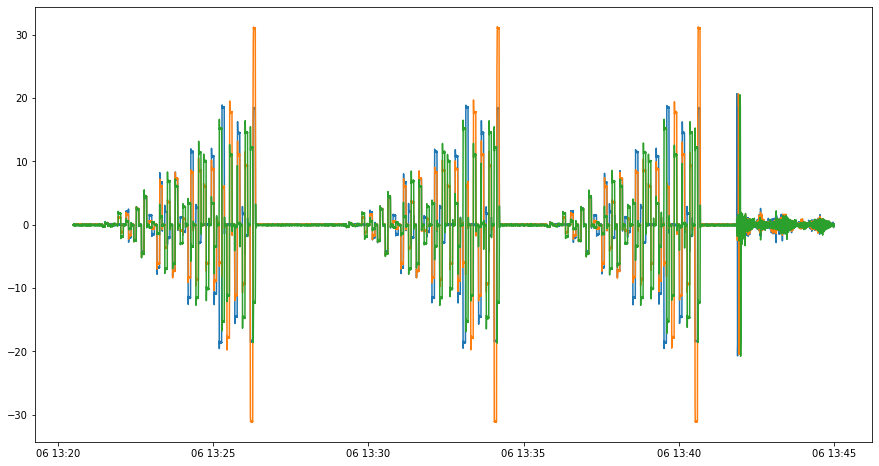

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(3):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['axialForceMeasured%d'%i]-df['axialForceMeasured%d'%i][0])